# Multi-fidelity Multi-objective Bayesian Optimization

Here we attempt to solve for the constrained Pareto front of the TNK multi-objective
optimization problem using Multi-Fidelity Multi-Objective Bayesian optimization. For
simplicity we assume that the objective and constraint functions at lower fidelities is
exactly equal to the functions at higher fidelities (this is obviously not a
requirement, although for the best results lower fidelity calculations should
correlate with higher fidelity ones). The algorithm should learn this relationship
and use information gathered at lower fidelities to gather samples to improve the
hypervolume of the Pareto front at the maximum fidelity.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
%reset -f

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch

from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MultiFidelityGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

evaluator = Evaluator(function=evaluate_TNK)
print(tnk_vocs.dict())

{'variables': {'x1': [0.0, 3.14159], 'x2': [0.0, 3.14159]}, 'constraints': {'c1': ['GREATER_THAN', 0.0], 'c2': ['LESS_THAN', 0.5]}, 'objectives': {'y1': 'MINIMIZE', 'y2': 'MINIMIZE'}, 'constants': {'a': 'dummy_constant'}, 'linked_variables': {}}


## Set up the Multi-Fidelity Multi-objective optimization algorithm
Here we create the Multi-Fidelity generator object which can solve both single and
multi-objective optimization problems depending on the number of objectives in VOCS.
We specify a cost function as a function of fidelity parameter $s=[0,1]$ as $C(s) =
s^{3.5}$ as an example from a real life multi-fidelity simulation problem.

In [2]:
options = MultiFidelityGenerator.default_options()
options.acq.reference_point = {"y1":1.5,"y2":1.5}

# set cost function according to approximate scaling of laser plasma accelerator
# problem, see https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.013063
options.acq.cost_function = lambda s: s**3.5
options.optim.num_restarts = 8
options.optim.raw_samples = 512

generator = MultiFidelityGenerator(tnk_vocs, options)
X = Xopt(generator=generator, evaluator=evaluator, vocs=tnk_vocs)

# evaluate at some explicit initial points
X.evaluate_data(pd.DataFrame({"x1":[1.0, 0.75],"x2":[0.75, 1.0],"s":[0.0,0.1]}))

X.generator.options.dict()

{'optim': {'num_restarts': 8,
  'raw_samples': 512,
  'sequential': True,
  'max_travel_distances': None,
  'use_turbo': False},
 'acq': {'proximal_lengthscales': None,
  'use_transformed_proximal_weights': True,
  'monte_carlo_samples': 128,
  'cost_function': <function __main__.<lambda>(s)>,
  'reference_point': {'y1': 1.5, 'y2': 1.5}},
 'model': {'name': 'standard',
  'custom_constructor': None,
  'use_low_noise_prior': True,
  'covar_modules': {},
  'mean_modules': {},
  'fidelity_parameter': 's'},
 'n_initial': 3,
 'use_cuda': False}

## Run optimization routine
Instead of ending the optimization routine after an explict number of samples we end
optimization once a given optimization budget has been exceeded. WARNING: This will
slightly exceed the given budget

In [3]:
budget = 10
while X.generator.calculate_total_cost() < budget:
    X.step()
    print(f"n_samples: {len(X.data)} "
          f"budget used: {X.generator.calculate_total_cost():.4} "
          f"hypervolume: {X.generator.calculate_hypervolume():.4}")

n_samples: 3 budget used: 0.01032 hypervolume: 0.0375
n_samples: 4 budget used: 0.02338 hypervolume: 0.1714
n_samples: 5 budget used: 0.03338 hypervolume: 0.1714
n_samples: 6 budget used: 0.04054 hypervolume: 0.2262
n_samples: 7 budget used: 0.07972 hypervolume: 0.2973
n_samples: 8 budget used: 0.4761 hypervolume: 0.2973
n_samples: 9 budget used: 0.4861 hypervolume: 0.2973
n_samples: 10 budget used: 0.4961 hypervolume: 0.3302
n_samples: 11 budget used: 0.5782 hypervolume: 0.393
n_samples: 12 budget used: 0.7213 hypervolume: 0.393
n_samples: 13 budget used: 0.8652 hypervolume: 0.54
n_samples: 14 budget used: 1.463 hypervolume: 0.54
n_samples: 15 budget used: 1.972 hypervolume: 0.707
n_samples: 16 budget used: 2.61 hypervolume: 0.7768
n_samples: 17 budget used: 2.772 hypervolume: 0.7768
n_samples: 18 budget used: 2.791 hypervolume: 0.7768
n_samples: 19 budget used: 3.009 hypervolume: 0.7768
n_samples: 20 budget used: 4.009 hypervolume: 0.7768
n_samples: 21 budget used: 5.009 hypervolume:

## Show results

In [5]:
X.data

{'x1': {1: 1.0,
  2: 0.75,
  3: 0.15745238540121814,
  4: 0.9468590006150636,
  5: 0.3170720612397151,
  6: 0.4071957007420707,
  7: 0.7522831858405871,
  8: 0.010088928367223707,
  9: 1.1975888274474822,
  10: 0.980294669552991,
  11: 0.570626788095057,
  12: 0.19868845107983804,
  13: 0.21085909691116655,
  14: 0.6630814704622766,
  15: 1.0899056165177718,
  16: 0.6551438176575906,
  17: 0.040706707042329315,
  18: 0.928803107842206,
  19: 0.3847109147066274,
  20: 0.7385742518799309,
  21: 0.7518004317616183,
  22: 0.8100761698758464,
  23: 1.0341823079775991,
  24: 0.03071524365242414,
  25: 0.09257515897486283,
  26: 0.13653607765367498,
  27: 0.16543599472005616,
  28: 0.1858638964288022,
  29: 1.054725195014607,
  30: 1.0371935414549696,
  31: 1.0498827165219113},
 'x2': {1: 0.75,
  2: 1.0,
  3: 1.65051039835285,
  4: 0.4910944798159445,
  5: 0.5960125300445138,
  6: 1.0110488639160982,
  7: 0.8055117744625027,
  8: 0.21572765084179543,
  9: 0.11147987574949422,
  10: 0.25496552

## Plot results
Here we plot the resulting observations in input space, colored by feasibility
(neglecting the fact that
these data points are at varying fidelities).


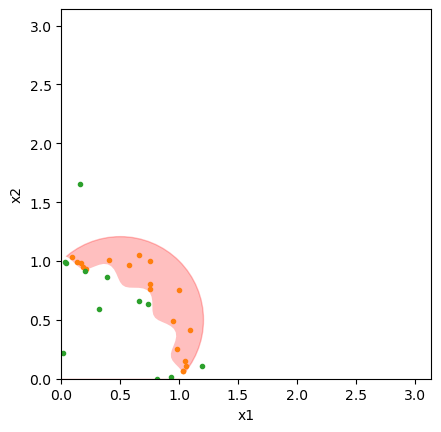

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5 ** 0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)

ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

### Plot path through input space

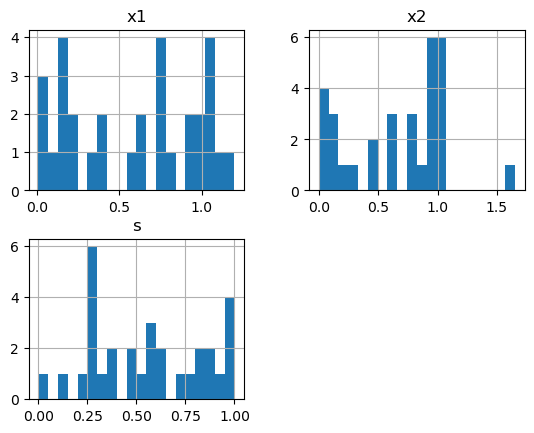

In [8]:
ax = history.hist(["x1", "x2", "s"],bins=20)

<Axes: >

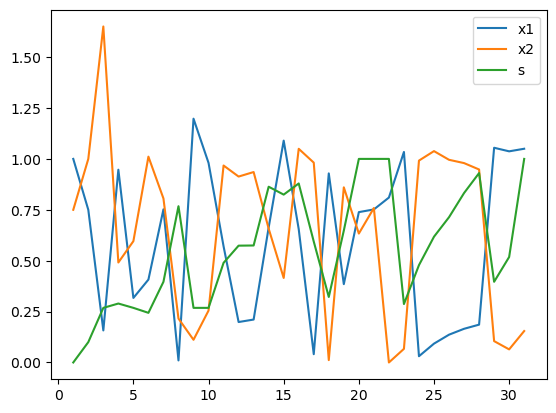

In [9]:
history.plot(y=["x1", "x2", "s"])

## Plot the acqusisition function
Here we plot the acquisition function at a small set of fidelities $[0, 0.5, 1.0]$.

[[0.95543209 0.27514659]]


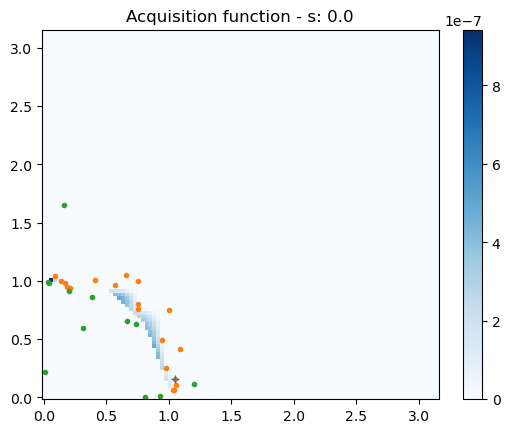

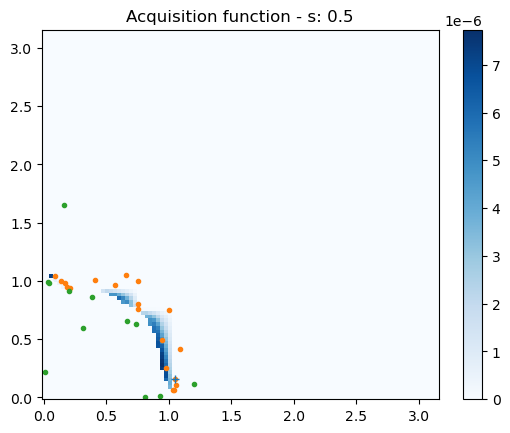

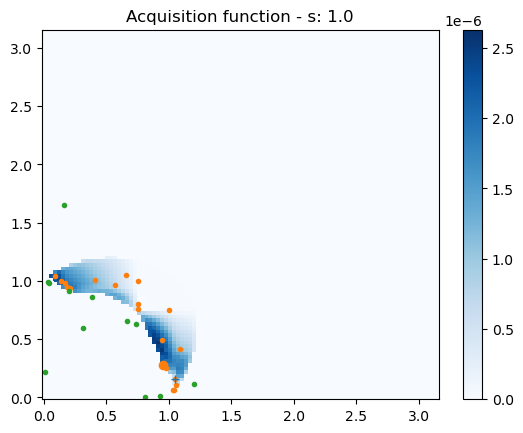

In [10]:
# plot the acquisition function
from xopt.generators.bayesian.objectives import feasibility

bounds = generator.vocs.bounds
model = generator.model

# create mesh over non-fidelity parameters
n = 100
x = torch.linspace(*bounds.T[1], n)
y = torch.linspace(*bounds.T[2], n)
xx, yy = torch.meshgrid(x, y)

# plot function(s) at a single fidelity parameter
fidelities = [0.0, 0.5, 1.0]
for fidelity in fidelities:
    pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()
    pts = torch.cat((torch.ones(pts.shape[0],1)*fidelity, pts), dim=-1)

    acq_func = generator.get_acquisition(model)
    with torch.no_grad():
        acq_pts = pts.unsqueeze(1)
        acq = acq_func(acq_pts)

        fig, ax = plt.subplots()
        c = ax.pcolor(xx, yy, acq.reshape(n, n), cmap="Blues")
        fig.colorbar(c)
        ax.set_title(f"Acquisition function - s: {fidelity}")

        ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
        ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

        ax.plot(*history[["x1", "x2"]].to_numpy()[-1].T, "+")


candidate = generator.generate(1)
print(candidate[["x1", "x2"]].to_numpy())
ax.plot(*candidate[["x1", "x2"]].to_numpy()[0], "o")

In [11]:
# examine lengthscale of the first objective
list(model.models[0].named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-26.0748], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(-0.1080, dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(0.9124, dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[0.8487, 1.3833, 1.5438]], dtype=torch.float64, requires_grad=True))]

In [12]:
# dump results to fiel
X.options.dump_file = "results.yaml"
X.dump_state()